### Import Libraries

In [1]:
import glob
import re
import pathlib
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import kaldiio
import numpy as np
import csv

import imblearn
import sklearn
from sklearn import datasets,metrics
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix as conf
from imblearn.over_sampling import SVMSMOTE,SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

### Extract SuperVectors

In [ ]:
def uttspkdict2(FOLDER_PATH,sound_mode):
    metadata = pd.read_csv('/home/oem/Desktop/DiCOVA/DiCOVA_Track_2_Release/metadata.csv')
    spkrlist = list(metadata['ID'])
    spkrlist.sort()
    uttspk = {}
    for a in range(len(spkrlist)):
        uttspk[spkrlist[a]] = str(spkrlist[a])+"-"+sound_mode+".wav"
    return uttspk


def writeuttspk2(TEXT_PATH,dictionary,mode):
    d_keys = dictionary.keys()
    newlines = []
    for spkr in d_keys:
        utt = dictionary[spkr]
        newline = utt + ' ' + spkr        
        newlines.append(newline)
    if (mode == 'new'):
        with open(TEXT_PATH,'w') as f:
            f.write("\n".join(newlines))
    elif (mode == 'append'):
        with open(TEXT_PATH,'a') as f:
            f.write("\n")
            f.write("\n".join(newlines))
    else:
        raise ValueError('Mode Not supported')
    return 

def gettext(wavpath,asr,mode):
    if(asr == 'aspire'):
        if (mode == 'convert'):
            text = "/usr/bin/sox -t wav " + wavpath + " -c 1 -b 16 -r 8000 -t wav - |"
        elif(mode == 'direct'):
            text = wavpath
    elif(asr == 'timit'):
        if (mode == 'convert'):
            text = "/home/oem/Desktop/kaldi/egs/timit/s5/../../../tools/sph2pipe_v2.5/sph2pipe -f wav " + wavpath + " |"
        elif(mode == 'direct'):
            text = wavpath
    return text

def writescp(spkr,utt,text,dictionary,TEXT_PATH,mode):
    d_keys = dictionary.keys()
    newlines = []
    newline = spkr+'-'+utt + ' ' + text        
    newlines.append(newline)
    if (mode == 'new'):
        with open(TEXT_PATH,'w') as f:
            f.write("\n".join(newlines))
    elif (mode == 'append'):
        with open(TEXT_PATH,'a') as f:
            f.write("\n")
            f.write("\n".join(newlines))
    else:
        raise ValueError('Mode Not supported')
    return 

#### Create utt2spk and wav.scp files for aspire

In [ ]:
sound_mode = "breathing-deep"
FOLDER_PATH = "/home/oem/Desktop/DiCOVA/Coswara/"+sound_mode ##Replace with your folder path of audio files
sub = [ f.path for f in os.scandir(FOLDER_PATH)]
sub.sort()

"""
Run this to get utt2spk file for aspire
"""

TEXT_PATH = '/home/oem/Desktop/DiCOVA/Coswara/utt2spk' ##Path_to_utt2spk
FOLDER_PATH = "/home/oem/Desktop/DiCOVA/Coswara/"+sound_mode
my_dict = uttspkdict2(FOLDER_PATH,sound_mode)
writeuttspk2(TEXT_PATH,my_dict,'append')


"""
Run this to get the wavscp file for aspire
"""
SCP_PATH = '/home/oem/Desktop/DiCOVA/Coswara/wav.scp'
wavpathlist = []
my_dict = uttspkdict2(FOLDER_PATH,sound_mode)
metadata = pd.read_csv('/home/oem/Desktop/DiCOVA/DiCOVA_Track_2_Release/metadata.csv')
spkrlist = list(metadata['ID'])
spkrlist.sort()
for k in range(len(spkrlist)):
    spkr = spkrlist[k]
    utt = sound_mode+".wav"
    print(utt)
    print(sub[k])
    wavpathlist.append(sub[k])
    txt = gettext(wavpathlist[k],'aspire','convert')
    if(k==0):
        writescp(spkr,utt,txt,my_dict,SCP_PATH,'new')           
    else:
        writescp(spkr,utt,txt,my_dict,SCP_PATH,'append') 

#### Format the posteriors files suitable to the next code

In [ ]:
Post = "/home/oem/Desktop/DiCOVA/posteriors/"
Post_dir = Post+"counting-normal/"
post_path = "/home/oem/Desktop/DiCOVA/posteriors/combined/post4.txt" ##Path to the text file with posteriors of all utterances
def modposts(post_path,Post_dir)
    with open(post_path) as f:
        lines = [line.rstrip() for line in f]
    if os.path.isdir(folder):
        print("Exists")
    else:
        print("Doesn't exist")
        os.mkdir(Post_dir)

    print(len(lines))
    for i in range(len(lines)):
        x = lines[i]
        y = x[:25]+"post"
        with open(Post_dir+y,'a') as f:
            z = x
            a = z.replace(" [",",[")
            f.write(a)
    return

#### Get Posterior matrices for each utterance

In [ ]:
def findphoneindexprob(filename,phone_index):
    f0 = open(filename,'r')
    array = f0.read().split(',')
    arr_indexprob=[]
    for i in range (1,len(array)):
        s0 = array[i]
        if  ' '+str(phone_index) + ' ' in s0:
            k=0
            start = ' '+str(phone_index)+' '
            s = array[i]
            p = s.find(start)+len(start)
            for space in s[p:]:
                if (space == ' '):
                    break
                k+=1
            arr_indexprob += [float(s[s.find(start)+len(start):s.find(start)+len(start)+k])]

        else:
            arr_indexprob += [0.0]
    return arr_indexprob

def findphoneprob(filename,phone):
    with open("phonemap.txt", 'r') as document:
        phonedict = {}
        for line in document:
            line = line.split()
            phonedict[line[0]] = line[1:]
    arr_phoneprob = np.zeros(len(findphoneindexprob(filename,200))) #200 is an arbitrary non phone_index
    for i in phonedict[phone]:
        arr_phoneprob = np.add(findphoneindexprob(filename,i),arr_phoneprob)
    return arr_phoneprob

def sentenceprob(filename):
    f = open("phonenames.txt",'r')
    phonenamearray = f.read().split(',')
    y = []
    for phone in phonenamearray:
        y += [findphoneprob(filename,phone)]
    y = np.array(y)    
    return y.T

### Get the First Order statistics

In [ ]:
def fstat(spkr,output_loc,mfcc_data,postprob_data,phoneclass,threshold,start,shift,framelength):
    for key in phoneclass:
        while ((start+framelength)<=len(mfcc_data)):
            mfcc = mfcc_data[start:(start+framelength)]
            postprob = postprob_data[start:(start+framelength)]
            postprob1 = postprob[:,phoneclass[key]]
            if(np.sum(np.sum(postprob1,axis=0)) > threshold):
                phonesum = np.sum(postprob1,axis = 0)
                for k in range(0,len(phonesum)):
                    if (phonesum[k] == 0):
                        phonesum[k] = 1e-8
                norm = np.divide(postprob1,phonesum)
                vector1 = (np.dot(norm.T,mfcc))
                vector = vector1.flatten()
                np.save(output_loc+key+'/'+spkr+'_'+str(start)+'.npy',vector)                    

            start+=shift    
    return

In [ ]:
phoneclass = {'full':np.arange(0,39)} ##Get all TIMIT phoneclasses
mfcc_dir = '/home/oem/Desktop/DiCOVA/feats/mfccnew/'
mfcc = os.listdir(mfcc_dir)
mfcc.sort()
post_dir = '/home/oem/Desktop/DiCOVA/posteriors/counting-normal/' ##Posteriors Directory 
post = os.listdir(post_dir)
post.sort()
output_loc = '/home/oem/Desktop/DiCOVA/stats/' ##Output Location
for i in range(len(mfcc)):
        mfcc_data = np.load(mfcc_dir+mfcc[i])
        postprob_data = sentenceprob(post_dir+post[i])
        threshold = 0
        start = 0
        shift = len(mfcc_data)
        framelength = len(mfcc_data)
        spkr = post[i][:-5]
        fstat(spkr,output_loc,mfcc_data,postprob_data,phoneclass,threshold,start,shift,framelength)

#### Get the MFCC files in npy format from the scp file

In [ ]:
PARENT_DIR = "/home/oem/Desktop/DiCOVA/Coswara"
FOLDER_PATH = "/home/oem/Desktop/DiCOVA/Coswara/vowel-e_fbank"
with open(FOLDER_PATH+"/feats.scp",'r') as f:
    for line in f:
        (key,rxfile) = line.split(' ')
        mfcc = kaldiio.load_mat(rxfile)
        mfcc = mfcc.mean(axis=0)
        np.save(PARENT_DIR+"/vowel-e_fbank/fbank_avg/"+key,mfcc)

### Get Lists for Harmonic features (These will be used the MATLAB codes)

In [ ]:
def makelist1(metadata_folder,audio_folder,out_folder,mode):
    md = pd.read_csv(metadata_folder+"metadata.csv")
    audio = os.listdir(audio_folder)
    audio.sort()
    
    ids = md['ID']
    line = []
    for i in range(len(audio)):
        if(ids[i]==audio[i][:8]):
            text = ids[i]+" "+audio_folder+ids[i]+"_"+mode+".wav"+" "+ out_folder+ids[i]+"_"+mode+"_harm1.txt"
            line.append(text) 
        else:
            break
        
    return line

def makelist2(metadata_folder,harm1_folder,out_folder,mode):
    md = pd.read_csv(metadata_folder+"metadata.csv")
    audio = os.listdir(audio_folder)
    audio.sort()
    
    ids = md['ID']
    line = []
    for i in range(len(audio)):
        if(ids[i]==audio[i][:8]):
            text = ids[i]+" "+harm1_folder+ids[i]+"_"+mode+"_harm1.txt"+" "+ out_folder+ids[i]+"_"+mode+"_harm2.txt"
            line.append(text) 
        else:
            break
        
    return line
    
def createtxt(array,listpath):
    with open(listpath, 'w') as f:
        for item in array:
            f.write("%s\n" % item)


In [ ]:
mode = breathing-deep
metadata_folder = "/home/oem/Desktop/DiCOVA/DiCOVA_Track_2_Release/" ## Path to metadata for DiCOVA challenge Data
audio_folder = "/home/oem/Desktop/DiCOVA/Coswara/"+mode+"/" ##Path to audio
out_folder = "/home/oem/Desktop/DiCOVA/Coswara/feats/"+mode+"/harmonics/"
out_folder1 = out_folder+"harm_int/"
out_folder2 = out_folder+"harm/"

list1 = makelist1(metadata_folder,audio_folder,out_folder1)
list2 = makelist2(metadata_folder,out_folder1,out_folder2)
createtxt(list1,out_folder+"list1.list")
createtxt(list2,out_folder+"list2.list")

### Get Lists for Formants features (These will be used by MATLAB codes)

In [ ]:
def makelist1(metadata_folder,audio_folder,out_folder,mode):
    md = pd.read_csv(metadata_folder+"metadata.csv")
    audio = os.listdir(audio_folder)
    audio.sort()
    
    ids = md['ID']
    line = []
    for i in range(len(audio)):
        if(ids[i]==audio[i][:8]):
            text = ids[i]+" "+audio_folder+ids[i]+"_"+mode+".wav"+" "+ out_folder+ids[i]+"_"+mode+"_formant1.txt"
            line.append(text) 
        else:
            break
        
    return line

def makelist2(metadata_folder,harm1_folder,out_folder,mode):
    md = pd.read_csv(metadata_folder+"metadata.csv")
    audio = os.listdir(audio_folder)
    audio.sort()
    
    ids = md['ID']
    line = []
    for i in range(len(audio)):
        if(ids[i]==audio[i][:8]):
            text = ids[i]+" "+harm1_folder+ids[i]+"_"+mode+"_formant1.txt"+" "+ out_folder+ids[i]+"_"+mode+"_formant2.txt"
            line.append(text) 
        else:
            break
        
    return line
    
def createtxt(array,listpath):
    with open(listpath, 'w') as f:
        for item in array:
            f.write("%s\n" % item)


In [ ]:
mode = "breathing-deep"
metadata_folder = "/home/oem/Desktop/DiCOVA/DiCOVA_Track_2_Release/"
audio_folder = "/home/oem/Desktop/DiCOVA/Coswara/"+mode+"/"
out_folder = "/home/oem/Desktop/DiCOVA/Coswara/feats/"+mode+"/formants_reduced/"
out_folder1 = out_folder+"formant_int/"
out_folder2 = out_folder+"formant/"

list1 = makelist1(metadata_folder,audio_folder,out_folder1,mode=mode)
list2 = makelist2(metadata_folder,out_folder1,out_folder2,mode=mode)
createtxt(list1,out_folder+"list1.list")
createtxt(list2,out_folder+"list2.list")

### Generate List Files for Train,Val and Eval

In [ ]:

##This function replaces 'n' and 'p' in categories to 0 and 1
def mod_metadata(metadata_path):
    metadata = pd.read_csv(metadata_path+'/metadata.csv')
    metadata = metadata.replace('p',1)
    md = metadata.replace('n',0)

    return md

##This function creates the training,validation and evaluation lists 
def getlists(md,fstats_folder,x_folder,mode):
    fstats = os.listdir(fstats_folder)
    fstats.sort()
    if(mode=="train" or mode=="val"):
        for i in range(1,6):
            if (mode=="val"):
                file = open('/home/oem/Desktop/DiCOVA/DiCOVA_Track_2_Release/LISTS/val_fold_'+str(i)+'.txt', 'r')
            elif(mode=="train"):
                file = open('/home/oem/Desktop/DiCOVA/DiCOVA_Track_2_Release/LISTS/train_fold_'+str(i)+'.txt', 'r')
            ids = file.readlines()
            ids = [line.strip() for line in ids]
            ids.sort()
            for j in range(len(fstats)):
                fstat = fstats[j]
                ID = fstat[:8]
                for k in range(len(ids)):
                    if(ID == ids[k]):
                        fn = list(md['ID'])
                        ind = fn.index(ID)
                        label = md['Covid_status'][ind]
                        text = fstats_folder+fstat+" "+str(label)
                        if (mode=="val"):
                            with open(x_folder+"val_fold_"+str(i)+".list",'a') as listfile:
                                listfile.write(text+"\n")
                        elif(mode=="train"):
                            with open(x_folder+"train_fold_"+str(i)+".list",'a') as listfile:
                                listfile.write(text+"\n")
                                
    elif(mode=="eval"):
        file = open('/home/oem/Desktop/DiCOVA/DiCOVA_Track_2_Release/LISTS/eval_list.txt', 'r')
        ids = file.readlines()
        ids = [line.strip() for line in ids]
        ids.sort()
        for j in range(len(fstats)):
            fstat = fstats[j]
            ID = fstat[:8]
            for k in range(len(ids)):
                if(ID == ids[k]):
                    fn = list(md['ID'])
                    ind = fn.index(ID)
                    label = md['Covid_status'][ind]
                    text = fstats_folder+fstat+" "+str(label)
                    with open(x_folder+"eval_list.list",'a') as listfile:
                        listfile.write(text+"\n")
                        
    else:
        return 


In [ ]:
metadata_path = '/home/oem/Desktop/DiCOVA/DiCOVA_Track_2_Release'
fstats_folder = '/home/oem/Desktop/DiCOVA/Coswara/feats/vowel-e/fbank/fbank_avg/'
x_folder = '/home/oem/Desktop/DiCOVA/Coswara/feats/vowel-e/fbank/'

In [ ]:
md = mod_metadata(metadata_path)
getlists(md,fstats_folder,x_folder,"train")
getlists(md,fstats_folder,x_folder,"val")
getlists(md,fstats_folder,x_folder,"eval")

### Load Train,Val and Eval features

In [2]:
##Use load_input1 to load .npy files path in your lists(Useful to load formants and harmonics features)
def load_input1(file_path,featdim):
    with open(file_path) as f:  
        line = f.readline()
        cnt = 1
        tr = np.empty(shape=[0,featdim])
        covid_trgt = []
        while line:
            [path,rem] = line.split()
            covid = float(rem)
            data_array = np.fromfile(path)
            da = np.reshape(data_array,(1,-1))
            covid_trgt.append(covid)
            tr = np.append(tr,da,axis=0)
            line = f.readline()
            cnt+=1
        print("train shape :",np.shape(tr), "targets shape :", np.shape(covid_trgt))
    return [tr,covid_trgt]


##Use load_input2 to load .npy files directly (Useful to load fstat and mfcc features)

def load_input2(file_path,featdim):
    with open(file_path) as f:  
        line = f.readline()
        cnt = 1
        tr = np.empty(shape=[0,featdim])
        covid_trgt = []
        while line:
            [path,rem] = line.split()
            covid = float(rem)
            data_array = np.load(path)
            da = np.reshape(data_array,(1,-1))
            covid_trgt.append(covid)
            tr = np.append(tr,da,axis=0)
            line = f.readline()
            cnt+=1
        print("train shape :",np.shape(tr), "targets shape :", np.shape(covid_trgt))
    return [tr,covid_trgt]

In [3]:
def data_dict1(data,feat_folder,feat_type,featdim):
    for i in range(1,6): 
        data["tr"+str(i)+"_X"],data["tr"+str(i)+"_Y"] = load_input1(feat_folder+feat_type+"/train_fold_"+str(i)+".list",featdim)

    for i in range(1,6):
        data["val"+str(i)+"_X"],data["val"+str(i)+"_Y"] = load_input1(feat_folder+feat_type+"/val_fold_"+str(i)+".list",featdim)

    data["eval_X"],data["eval_Y"] =load_input1(feat_folder+feat_type+"/eval_list.list",featdim)
    
    return data

def data_dict2(data,feat_folder,feat_type,featdim):
    for i in range(1,6): 
        data["tr"+str(i)+"_X"],data["tr"+str(i)+"_Y"] = load_input2(feat_folder+feat_type+"/train_fold_"+str(i)+".list",featdim)

    for i in range(1,6):
        data["val"+str(i)+"_X"],data["val"+str(i)+"_Y"] = load_input2(feat_folder+feat_type+"/val_fold_"+str(i)+".list",featdim)

    data["eval_X"],data["eval_Y"] =load_input2(feat_folder+feat_type+"/eval_list.list",featdim)
    
    return data

In [4]:
""" Counting Normal Dataset"""
feat_folder = "/home/oem/Desktop/DiCOVA/Coswara/feats/counting-normal/"

feat_type2 = "formants"
featdim2 = 30
count_form = {}
count_form = data_dict1(count_form,feat_folder,feat_type2,featdim2)

feat_type3 = "harmonics"
featdim3 = 180
count_harm = {}
count_harm = data_dict1(count_harm,feat_folder,feat_type3,featdim3)

feat_type1 = "fstats"
featdim1 = 1560
count_fstats={}
count_fstats = data_dict2(count_fstats,feat_folder,feat_type1,featdim1)

train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (209, 30) targets shape : (209,)
train shape : (783, 180) targets shape : (783,)
train shape : (783, 180) targets shape : (783,)
train shape : (783, 180) targets shape : (783,)
train shape : (783, 180) targets shape : (783,)
train shape : (783, 180) targets shape : (783,)
train shape : (207, 180) targets shape : (207,)
train shape : (207, 180) targets shape : (207,)
train shape : (207, 180) targets shape : (207,)
train shape : (207, 180) targets shape : (207,)
train shape : (207, 180) targets shape : (207,)
tra

In [5]:
""" Vowel-e Dataset"""
feat_folder = "/home/oem/Desktop/DiCOVA/Coswara/feats/vowel-e/"

feat_type1 = "formants"
featdim1 = 30
vowel_form = {}
vowel_form = data_dict1(vowel_form,feat_folder,feat_type1,featdim1)

feat_type2 = "harmonics"
featdim2 = 180
vowel_harm = {}
vowel_harm = data_dict1(vowel_harm,feat_folder,feat_type2,featdim2)

feat_type3 = "fbank"
featdim3 = 40
vowel_fbank = {}
vowel_fbank = data_dict2(vowel_fbank,feat_folder,feat_type3,featdim3)

train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (783, 30) targets shape : (783,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (207, 30) targets shape : (207,)
train shape : (209, 30) targets shape : (209,)
train shape : (783, 180) targets shape : (783,)
train shape : (783, 180) targets shape : (783,)
train shape : (783, 180) targets shape : (783,)
train shape : (783, 180) targets shape : (783,)
train shape : (783, 180) targets shape : (783,)
train shape : (207, 180) targets shape : (207,)
train shape : (207, 180) targets shape : (207,)
train shape : (207, 180) targets shape : (207,)
train shape : (207, 180) targets shape : (207,)
train shape : (207, 180) targets shape : (207,)
tra

In [6]:
""" Breathing-Deep Dataset"""
feat_folder = "/home/oem/Desktop/DiCOVA/Coswara/feats/breathing-deep/"
feat_type = "formants_reduced"
featdim = 24
breath_form = {}
breath_form = data_dict1(breath_form,feat_folder,feat_type,featdim)

feat_type2 = "fbank"
featdim2 = 40
breath_fbank = {}
breath_fbank = data_dict2(breath_fbank,feat_folder,feat_type2,featdim2)

train shape : (783, 24) targets shape : (783,)
train shape : (783, 24) targets shape : (783,)
train shape : (783, 24) targets shape : (783,)
train shape : (783, 24) targets shape : (783,)
train shape : (783, 24) targets shape : (783,)
train shape : (207, 24) targets shape : (207,)
train shape : (207, 24) targets shape : (207,)
train shape : (207, 24) targets shape : (207,)
train shape : (207, 24) targets shape : (207,)
train shape : (207, 24) targets shape : (207,)
train shape : (209, 24) targets shape : (209,)
train shape : (783, 40) targets shape : (783,)
train shape : (783, 40) targets shape : (783,)
train shape : (783, 40) targets shape : (783,)
train shape : (783, 40) targets shape : (783,)
train shape : (783, 40) targets shape : (783,)
train shape : (207, 40) targets shape : (207,)
train shape : (207, 40) targets shape : (207,)
train shape : (207, 40) targets shape : (207,)
train shape : (207, 40) targets shape : (207,)
train shape : (207, 40) targets shape : (207,)
train shape :

### Classifier

In [32]:

def score_auc(estimator, X, y):
    y_score = estimator.decision_function(X) 
    probs = y_score
    return y_score,roc_auc_score(y, probs)

def sens_spec(Conf):
    sens = (Conf[1][1])/(Conf[1][1]+Conf[1][0])
    spec = (Conf[0][0])/(Conf[0][1]+Conf[0][0])
    return sens,spec

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

def compute_eer(fpr,tpr,thresholds):
    fnr = 1-tpr
#     eer_threshold=thresholds[np.argmax(np.sqrt(tpr*(1-fpr)))]
    eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
    return eer_threshold

def SVM(train_X,train_Y,val_X,val_Y,C):
    clf = svm.SVC(C=C,class_weight="balanced",probability=True)
    clf.fit(train_X,train_Y)
    probs = clf.decision_function(val_X)
    probs = 1/(1+np.exp(-1*probs))
    return probs

In [33]:
def run_SVM_CV(data,C,pred,balance=False):
    y_hard={}
    folds = list(data.keys())
    for i in range(0,(len(folds)-2)//2,2):
        if (balance==False):
            print("Folds:",i//2+1)
            y_prob = SVM(data[folds[i]],data[folds[i+1]],data[folds[i+10]],data[folds[i+11]],C)
            fpr, tpr, t = metrics.roc_curve(data[folds[i+11]], y_prob)
            auc = metrics.auc(fpr,tpr)
            best_thresh =compute_eer(fpr,tpr,t) 
            hard = to_labels(y_prob,best_thresh)
            confusion = conf(data[folds[i+11]],hard)
            sens,spec = sens_spec(confusion)
            print("Sens:",sens,"Spec:",spec)
            print("auc:",auc)
            pred["pred_fold_"+str((i//2+1))] = y_prob
            y_hard["hard_fold_"+str((i//2+1))] = hard
        else:
            X,Y = balance_dist(data[folds[i]],data[folds[i+1]],700)
            y_prob = SVM(X,Y,data[folds[i+10]],data[folds[i+11]],C)
            pred["pred_fold_"+str((i//2+1))] = y_prob
    return y_hard,pred

def run_SVM_eval(data,C,balance=False):
    folds = list(data.keys())
    if (balance==False):
        tr_X = np.concatenate((data[folds[0]],data[folds[10]]))
        tr_Y = np.concatenate((data[folds[1]],data[folds[11]]))
        val_X,val_Y = data[folds[20]],data[folds[21]]
        y_prob = SVM(tr_X,tr_Y,val_X,val_Y,C)

    return val_Y,y_prob

In [34]:
def score(testy,probs):
    thresholds = np.arange(-1, 1, 0.001)
    scores = [perf_measure(testy, to_labels(probs, t)) for t in thresholds]
    scores = np.subtract(scores,[0.8]*len(scores))
    ix = np.argmin(np.abs(scores))
    print(scores)
    best_thresh = thresholds[ix]
    return best_thresh
    

def avg_CV(data,data_soft):
    folds = list(data.keys())
    fds = list(data_soft.keys())
    y_true = np.concatenate([data[folds[i+11]] for i in range(0,(len(folds)-2)//2,2)])
    probs = np.concatenate([data_soft[fds[j]] for j in range(0,5)])
    fpr, tpr, thresholds = metrics.roc_curve(y_true, probs)
    auc = metrics.auc(fpr,tpr)
    best_thresh = compute_eer(fpr,tpr,thresholds)
    hard = to_labels(probs,best_thresh)
    confusion = conf(y_true,hard)
    sens,spec = sens_spec(confusion)
    print("Sens:",sens,"Spec:",spec)
    print("auc:",auc)
    print(confusion)
    return hard,best_thresh


def avg_eval(data,best_thresh,C,feat,data_type):
    y_true,probs = run_SVM_eval(data,C)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, probs)
    thresh = compute_eer(fpr,tpr,thresholds)
    auc = metrics.auc(fpr,tpr)
    hard = to_labels(probs,best_thresh)
    confusion = conf(y_true,hard)
    sens,spec = sens_spec(confusion)
    print("Sens:",sens,"Spec:",spec)
    print("auc:",auc)
    print(confusion)
    return probs,hard


def plot_roc(y_test,preds,feat,data_type):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title(data_type+' ROC')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.plot(fpr, tpr, label = feat+', AUC=%0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    return

## MAKE PREDICTIONS!

### Counting-Normal

In [35]:
count_fstats_soft={}
count_form_soft={}
count_harm_soft={}

count_fstats_hard={}
count_form_hard={}
count_harm_hard={}

In [53]:
C=[0.1]
for j in range(len(C)):
    print("C:",C[j])
    count_fstats_hard,count_fstats_soft = run_SVM_CV(count_fstats,C[j],count_fstats_soft,balance=False)
    x,count_fstats_thresh = avg_CV(count_fstats,count_fstats_soft)
count_fstats_eval_soft,count_fstats_eval_hard=avg_eval(count_fstats,count_fstats_thresh,C[0],feat="fstats",data_type="Counting-Normal")

C: 0.1
Folds: 1
Sens: 0.6190476190476191 Spec: 0.6397849462365591
auc: 0.6372247823860727
Folds: 2
Sens: 0.5714285714285714 Spec: 0.543010752688172
auc: 0.6523297491039426
Folds: 3
Sens: 0.6190476190476191 Spec: 0.6129032258064516
auc: 0.6402969790066564
Folds: 4
Sens: 0.6666666666666666 Spec: 0.6505376344086021
auc: 0.6300563236047106
Folds: 5
Sens: 0.7142857142857143 Spec: 0.6774193548387096
auc: 0.6981566820276497
Sens: 0.6095238095238096 Spec: 0.613978494623656
auc: 0.6418535586277521
[[571 359]
 [ 41  64]]
Sens: 0.6190476190476191 Spec: 0.5691489361702128
auc: 0.6377912867274569
[[107  81]
 [  8  13]]


In [37]:
C=[1e1]
for j in range(len(C)):
    print("C:",C[j])
    count_harm_hard,count_harm_soft = run_SVM_CV(count_harm,C[j],count_harm_soft,balance=False)
    x,count_harm_thresh = avg_CV(count_harm,count_harm_soft)
count_harm_eval_soft,count_harm_eval_hard=avg_eval(count_harm,count_harm_thresh,C[0],feat="harm",data_type="Counting-Normal")

C: 10.0
Folds: 1
Sens: 0.6666666666666666 Spec: 0.6451612903225806
auc: 0.7204301075268817
Folds: 2
Sens: 0.5714285714285714 Spec: 0.5860215053763441
auc: 0.6379928315412187
Folds: 3
Sens: 0.6190476190476191 Spec: 0.6290322580645161
auc: 0.6451612903225806
Folds: 4
Sens: 0.6190476190476191 Spec: 0.6344086021505376
auc: 0.6164874551971327
Folds: 5
Sens: 0.5714285714285714 Spec: 0.521505376344086
auc: 0.6113671274961597
Sens: 0.6095238095238096 Spec: 0.6086021505376344
auc: 0.6408602150537636
[[566 364]
 [ 41  64]]
Sens: 0.5238095238095238 Spec: 0.6542553191489362
auc: 0.6519756838905775
[[123  65]
 [ 10  11]]


In [38]:
C=[1e1]
for j in range(len(C)):
    print("C:",C[j])
    count_form_hard,count_form_soft = run_SVM_CV(count_form,C[j],count_form_soft,balance=False)
    x,count_form_thresh = avg_CV(count_form,count_form_soft)
    
count_form_eval_soft,count_form_eval_hard=avg_eval(count_form,count_form_thresh,C[0],feat="form",data_type="Counting-Normal")

C: 10.0
Folds: 1
Sens: 0.6666666666666666 Spec: 0.6612903225806451
auc: 0.7621607782898105
Folds: 2
Sens: 0.6666666666666666 Spec: 0.6881720430107527
auc: 0.6715309779825909
Folds: 3
Sens: 0.6190476190476191 Spec: 0.6129032258064516
auc: 0.6344086021505376
Folds: 4
Sens: 0.6190476190476191 Spec: 0.6021505376344086
auc: 0.631336405529954
Folds: 5
Sens: 0.5714285714285714 Spec: 0.5752688172043011
auc: 0.6643625192012288
Sens: 0.6285714285714286 Spec: 0.6258064516129033
auc: 0.666041986687148
[[582 348]
 [ 39  66]]
Sens: 0.7142857142857143 Spec: 0.6170212765957447
auc: 0.6973150962512664
[[116  72]
 [  6  15]]


### Vowel-/i/

In [39]:
vowel_form_soft = {}
vowel_harm_soft = {}
vowel_fbank_soft = {}

vowel_form_hard = {}
vowel_harm_hard = {}
vowel_fbank_hard = {}

In [40]:
C=[1000]
for j in range(len(C)):
    print("C:",C[j])
    vowel_harm_hard,vowel_harm_soft = run_SVM_CV(vowel_harm,C[j],vowel_harm_soft,balance=False)
    x,vowel_harm_thresh = avg_CV(vowel_harm,vowel_harm_soft)
vowel_harm_eval_soft,vowel_harm_eval_hard=avg_eval(vowel_harm,vowel_harm_thresh,C[0],feat="harm",data_type="Vowel-/i/")

C: 1000
Folds: 1
Sens: 0.6666666666666666 Spec: 0.6720430107526881
auc: 0.6899641577060932
Folds: 2
Sens: 0.5714285714285714 Spec: 0.6559139784946236
auc: 0.6223758320532513
Folds: 3
Sens: 0.6190476190476191 Spec: 0.6612903225806451
auc: 0.6346646185355863
Folds: 4
Sens: 0.6190476190476191 Spec: 0.6182795698924731
auc: 0.7004608294930876
Folds: 5
Sens: 0.47619047619047616 Spec: 0.46774193548387094
auc: 0.5207373271889402
Sens: 0.6 Spec: 0.6236559139784946
auc: 0.6321351766513057
[[580 350]
 [ 42  63]]
Sens: 0.6190476190476191 Spec: 0.5585106382978723
auc: 0.585612968591692
[[105  83]
 [  8  13]]


In [41]:
C=[1]
for j in range(len(C)):
    print("C:",C[j])
    vowel_form_hard,vowel_form_soft = run_SVM_CV(vowel_form,C[j],vowel_form_soft,balance=False)
    x,vowel_form_thresh = avg_CV(vowel_form,vowel_form_soft)
vowel_form_eval_soft,vowel_form_eval_hard = avg_eval(vowel_form,vowel_form_thresh,C[0],feat="form",data_type="Vowel-/i/")

C: 1
Folds: 1
Sens: 0.5714285714285714 Spec: 0.5698924731182796
auc: 0.634152585765489
Folds: 2
Sens: 0.5714285714285714 Spec: 0.5268817204301075
auc: 0.6513056835637481
Folds: 3
Sens: 0.6666666666666666 Spec: 0.6881720430107527
auc: 0.7050691244239631
Folds: 4
Sens: 0.5238095238095238 Spec: 0.5376344086021505
auc: 0.602662570404506
Folds: 5
Sens: 0.5238095238095238 Spec: 0.5161290322580645
auc: 0.5593958013312852
Sens: 0.6 Spec: 0.5967741935483871
auc: 0.6190783410138249
[[555 375]
 [ 42  63]]
Sens: 0.5714285714285714 Spec: 0.6329787234042553
auc: 0.5828267477203648
[[119  69]
 [  9  12]]


In [42]:
C=[1]
for j in range(len(C)):
    print("C:",C[j])
    vowel_fbank_hard,vowel_fbank_soft = run_SVM_CV(vowel_fbank,C[j],vowel_fbank_soft,balance=False)
    x,vowel_fbank_thresh = avg_CV(vowel_fbank,vowel_fbank_soft)
vowel_fbank_eval_soft,vowel_fbank_eval_hard=avg_eval(vowel_fbank,vowel_fbank_thresh,C[0],feat="fbank",data_type="Vowel-/i/")

C: 1
Folds: 1
Sens: 0.6666666666666666 Spec: 0.6720430107526881
auc: 0.7178699436763952
Folds: 2
Sens: 0.6190476190476191 Spec: 0.6505376344086021
auc: 0.6833077316948285
Folds: 3
Sens: 0.6666666666666666 Spec: 0.6774193548387096
auc: 0.7327188940092165
Folds: 4
Sens: 0.6190476190476191 Spec: 0.6397849462365591
auc: 0.655657962109575
Folds: 5
Sens: 0.6190476190476191 Spec: 0.6182795698924731
auc: 0.6400409626216078
Sens: 0.6476190476190476 Spec: 0.6494623655913978
auc: 0.6874859190988224
[[604 326]
 [ 37  68]]
Sens: 0.47619047619047616 Spec: 0.6223404255319149
auc: 0.6030901722391084
[[117  71]
 [ 11  10]]


### Breathing-Deep

In [43]:
breath_form_soft={}
breath_form_hard={}
breath_fbank_soft={}
breath_fbank_hard={}

In [44]:
C=[10]
for j in range(len(C)):
    print("C:",C[j])
    breath_fbank_hard,breath_fbank_soft = run_SVM_CV(breath_fbank,C[j],breath_fbank_soft,balance=False)
    x,breath_fbank_thresh = avg_CV(breath_fbank,breath_fbank_soft)
breath_fbank_eval_soft,breath_fbank_eval_hard=avg_eval(breath_fbank,breath_fbank_thresh,C[0],feat="fbank",data_type="Breathing-Deep")

C: 10
Folds: 1
Sens: 0.5714285714285714 Spec: 0.5645161290322581
auc: 0.6052227342549923
Folds: 2
Sens: 0.5714285714285714 Spec: 0.553763440860215
auc: 0.5509472606246799
Folds: 3
Sens: 0.6190476190476191 Spec: 0.5698924731182796
auc: 0.6707629288274449
Folds: 4
Sens: 0.6190476190476191 Spec: 0.6129032258064516
auc: 0.6561699948796723
Folds: 5
Sens: 0.5714285714285714 Spec: 0.5698924731182796
auc: 0.6077828981054787
Sens: 0.580952380952381 Spec: 0.5817204301075268
auc: 0.6141218637992831
[[541 389]
 [ 44  61]]
Sens: 0.5238095238095238 Spec: 0.5531914893617021
auc: 0.5924518743667679
[[104  84]
 [ 10  11]]


In [46]:
C=[100]
for j in range(len(C)):
    print("C:",C[j])
    breath_form_hard,breath_form_soft = run_SVM_CV(breath_form,C[j],breath_form_soft,balance=False)
    x,breath_form_thresh = avg_CV(breath_form,breath_form_soft)
breath_form_eval_soft,breath_form_eval_hard=avg_eval(breath_form,breath_form_thresh,C[0],feat="form",data_type="Breathing-Deep")

C: 100
Folds: 1
Sens: 0.6190476190476191 Spec: 0.5860215053763441
auc: 0.6618023553507424
Folds: 2
Sens: 0.5714285714285714 Spec: 0.5698924731182796
auc: 0.6385048643113159
Folds: 3
Sens: 0.5714285714285714 Spec: 0.5645161290322581
auc: 0.6223758320532514
Folds: 4
Sens: 0.6190476190476191 Spec: 0.6290322580645161
auc: 0.6986687147977471
Folds: 5
Sens: 0.5714285714285714 Spec: 0.5698924731182796
auc: 0.6344086021505376
Sens: 0.6095238095238096 Spec: 0.6129032258064516
auc: 0.6508141321044547
[[570 360]
 [ 41  64]]
Sens: 0.6666666666666666 Spec: 0.5904255319148937
auc: 0.7173252279635258
[[111  77]
 [  7  14]]


### Combine Classifier Outputs

In [74]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

def plot_roc(y_test,preds,feat,data_type):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title(data_type+' ROC')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.plot(fpr, tpr, label = feat+', AUC=%0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    return

def auc_avg_CV(data,data_pred,feat,data_type):
    folds = list(data.keys())
    fds = list(data_pred.keys())
    X = np.concatenate([data[folds[i+11]] for i in range(0,(len(folds)-2)//2,2)])
    Y = np.concatenate([data_pred[fds[j]] for j in range(0,5)])
    plot_roc(X,Y,feat,data_type)
    return

def auc_eval(data,pred,feat,data_type):
    folds = list(data.keys())
    X = data[folds[21]]
    Y = pred
    plot_roc(X,Y,feat,data_type)
    return

def avg_CV_eval(data,pred,feat,data_type):
    folds = list(data.keys())
    X = data[folds[21]]
    Y = pred
    fpr, tpr, thresholds = metrics.roc_curve(X,Y)
    auc = metrics.auc(fpr,tpr)
    best_thresh = compute_eer(fpr,tpr,thresholds)
    hard = to_labels(Y,best_thresh)
    confusion = conf(X,hard)
    sens,spec = sens_spec(confusion)
    print("Sens:",sens,"Spec:",spec)
    print("auc:",auc)
    plot_roc(X,Y,feat,data_type)
    return

def avg_CV(data,data_pred,feat,data_type):
    folds = list(data.keys())
    fds = list(data_pred.keys())
    X = np.concatenate([data[folds[i+11]] for i in range(0,(len(folds)-2)//2,2)])
    Y = np.concatenate([data_pred[fds[j]] for j in range(0,5)])
    fpr, tpr, thresholds = metrics.roc_curve(X,Y)
    auc = metrics.auc(fpr,tpr)
    best_thresh = compute_eer(fpr,tpr,thresholds)
    hard = to_labels(Y,best_thresh)
    confusion = conf(X,hard)
    sens,spec = sens_spec(confusion)
    print("Sens:",sens,"Spec:",spec)
    print("AUC:",auc)
    print(confusion)
    plot_roc(X,Y,feat,data_type)
    return auc

### Plot ROC Curves

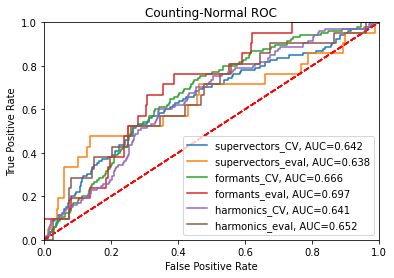

In [55]:
data_type = 'Counting-Normal'
auc_avg_CV(count_fstats,count_fstats_soft,feat='supervectors_CV',data_type=data_type)
auc_eval(count_fstats,count_fstats_eval_soft,feat='supervectors_eval',data_type=data_type)
auc_avg_CV(count_form,count_form_soft,feat='formants_CV',data_type=data_type)
auc_eval(count_form,count_form_eval_soft,feat='formants_eval',data_type=data_type)
auc_avg_CV(count_harm,count_harm_soft,feat='harmonics_CV',data_type=data_type)
auc_eval(count_harm,count_harm_eval_soft,feat='harmonics_eval',data_type=data_type)

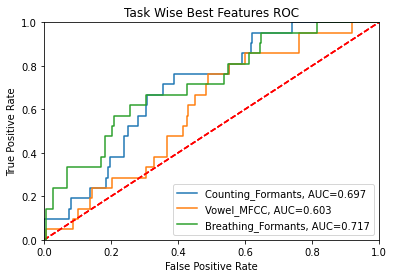

In [77]:
data_type = "Task Wise Best Features"
# auc_eval(count_fstats,count_fstats_eval_soft,feat='Counting_Supervectors',data_type=data_type)
auc_eval(count_form,count_form_eval_soft,feat='Counting_Formants',data_type=data_type)
# auc_eval(count_harm,count_harm_eval_soft,feat='Counting_Harmonics',data_type=data_type)
auc_eval(vowel_fbank,vowel_fbank_eval_soft,feat='Vowel_MFCC',data_type=data_type)
# auc_eval(vowel_form,vowel_form_eval_soft,feat='Vowel_Formants',data_type=data_type)
# auc_eval(vowel_harm,vowel_harm_eval_soft,feat='Breathing_Harmonics',data_type=data_type)
auc_eval(breath_form,breath_form_eval_soft,feat='Breathing_Formants',data_type=data_type)
# auc_eval(breath_fbank,breath_fbank_eval_soft,feat='Breathing_MFCC',data_type=data_type)

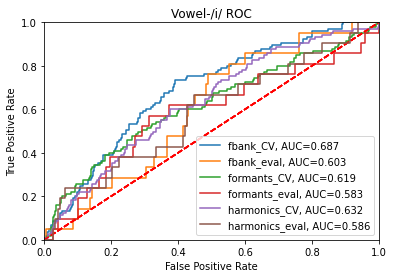

In [56]:
data_type = 'Vowel-/i/'
auc_avg_CV(vowel_fbank,vowel_fbank_soft,feat='fbank_CV',data_type=data_type)
auc_eval(vowel_fbank,vowel_fbank_eval_soft,feat='fbank_eval',data_type=data_type)

auc_avg_CV(vowel_form,vowel_form_soft,feat='formants_CV',data_type=data_type)
auc_eval(vowel_form,vowel_form_eval_soft,feat='formants_eval',data_type=data_type)

auc_avg_CV(vowel_harm,vowel_harm_soft,feat='harmonics_CV',data_type=data_type)
auc_eval(vowel_harm,vowel_harm_eval_soft,feat='harmonics_eval',data_type=data_type)

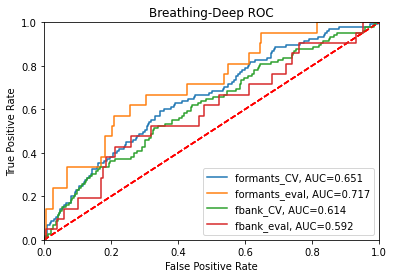

In [57]:
data_type = 'Breathing-Deep'
auc_avg_CV(breath_form,breath_form_soft,feat='formants_CV',data_type=data_type)
auc_eval(breath_form,breath_form_eval_soft,feat='formants_eval',data_type=data_type)
auc_avg_CV(breath_fbank,breath_fbank_soft,feat='fbank_CV',data_type=data_type)
auc_eval(breath_fbank,breath_fbank_eval_soft,feat='fbank_eval',data_type=data_type)

### Different Types of Fusion Of Features

In [58]:
def run_maxvoting3(data1,data2,data3):
    pred={}
    folds = list(data2.keys())
#     print(folds[0])
    for i in range(len(folds)):
        pred1 = data1[folds[i]]
        pred2 = data2[folds[i]]
        pred3 = data3[folds[i]]
        pred[folds[i]] = (data1[folds[i]]+data2[folds[i]]+data3[folds[i]])/3
    return pred

def run_maxvoting6(data1,data2,data3,data4,data5,data6):
    pred={}
    folds = list(data2.keys())
#     print(folds[0])
    for i in range(len(folds)):
        pred1 = data1[folds[i]]
        pred2 = data2[folds[i]]
        pred3 = data3[folds[i]]
        pred4 = data4[folds[i]]
        pred5 = data5[folds[i]]
        pred6 = data6[folds[i]]
        pred[folds[i]] = (pred1+pred2+pred3+pred4+pred5+pred6)/6
    return pred


def run_maxvoting2(data1,data2):
    pred={}
    folds = list(data1.keys())
    for i in range(len(folds)):
        pred1 = data1[folds[i]]
        pred2 = data2[folds[i]]
        pred[folds[i]] = (pred1+pred2)/2
        
    return pred

def run_maxvoting_eval3(data1,data2,data3):
    pred = (data1+data2+data3)/3
    return pred

def run_maxvoting_eval2(data1,data2):
    pred = (data1+data2)/2
    return pred

def run_maxvoting_eval6(data1,data2,data3,data4,data5,data6):
    pred = (data1+data2+data3+data4+data5+data6)/6
    return pred


def thresh_eval1(pred):
    a = pred
    a[a<=1] = 0
    a[a>1] = 1
    
    pred = a
        
    return pred

def avgvote3(hard1,hard2,hard3):
    pred={}
    pred = run_maxvoting3(hard1,hard2,hard3)
    fds = list(pred.keys())
    x = pred
        
    return x

def avgvote2(hard1,hard2):
    pred={}
    pred = run_maxvoting2(hard1,hard2)
    fds = list(pred.keys())
    x = pred
        
    return x

def avgvote6(hard1,hard2,hard3,hard4,hard5,hard6):
    pred={}
    pred = run_maxvoting6(hard1,hard2,hard3,hard4,hard5,hard6)
    fds = list(pred.keys())
    x = pred
        
    return x

def avgvote_eval3(hard1,hard2,hard3):
    pred = run_maxvoting_eval3(hard1,hard2,hard3)
    x = pred
    return x

def avgvote_eval2(hard1,hard2):
    pred = run_maxvoting_eval2(hard1,hard2)
    x = pred
    return x

def avgvote_eval6(hard1,hard2,hard3,hard4,hard5,hard6):
    pred = run_maxvoting_eval6(hard1,hard2,hard3,hard4,hard5,hard6)
    x = pred
    return x

### Combine All Features in A Task

Sens: 0.638095238095238 Spec: 0.6376344086021506
AUC: 0.6834203789042499
[[593 337]
 [ 38  67]]
Sens: 0.6190476190476191 Spec: 0.6170212765957447
auc: 0.6752786220871327


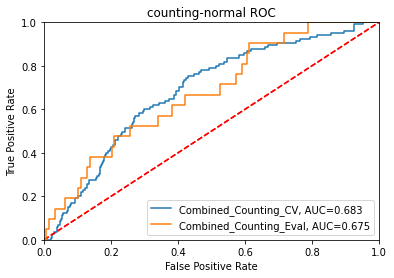

In [64]:
x2 = maxvote3(count_form_soft,count_harm_soft,count_fstats_soft)
conf2 = avg_CV(count_form,x2,feat="Combined_Counting_CV",data_type="counting-normal")
x1 = maxvote_eval3(count_fstats_eval_soft,count_form_eval_soft,count_harm_eval_soft)
conf1 = avg_CV_eval(count_harm,x1,feat="Combined_Counting_Eval",data_type='counting-normal')

Sens: 0.6285714285714286 Spec: 0.6279569892473118
AUC: 0.6774091141833077
[[584 346]
 [ 39  66]]
Sens: 0.5714285714285714 Spec: 0.574468085106383
auc: 0.6106889564336373


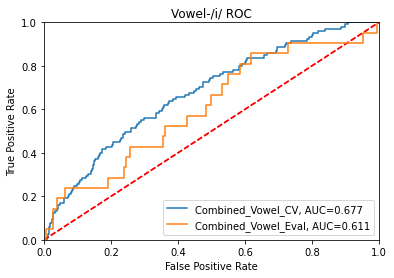

In [60]:
x3 = maxvote3(vowel_form_soft,vowel_harm_soft,vowel_fbank_soft)
conf3 = avg_CV(vowel_form,x3,feat="Combined_Vowel_CV",data_type="Vowel-/i/")
x4 = maxvote_eval3(vowel_form_eval_soft,vowel_harm_eval_soft,vowel_fbank_eval_soft)
conf4 = avg_CV_eval(vowel_form,x4,feat="Combined_Vowel_Eval",data_type='Vowel-/i/')

Sens: 0.6 Spec: 0.6075268817204301
AUC: 0.6535279057859703
[[565 365]
 [ 42  63]]
Sens: 0.6190476190476191 Spec: 0.675531914893617
auc: 0.6909827760891589


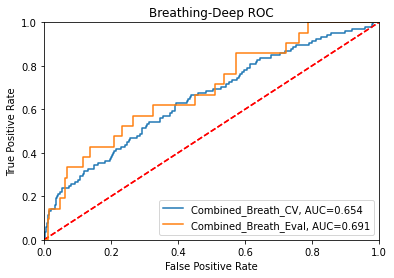

In [61]:
x5 = maxvote2(breath_form_soft,breath_fbank_soft)
conf5 = avg_CV(breath_form,x5,feat="Combined_Breath_CV",data_type = "Breathing-Deep")
x6 = maxvote_eval2(breath_form_eval_soft,breath_fbank_eval_soft)
conf6 = avg_CV_eval(breath_form,x6,feat="Combined_Breath_Eval",data_type="Breathing-Deep")

### Combine All Features

Sens: 0.6666666666666666 Spec: 0.6709677419354839
AUC: 0.7341116231438812
[[624 306]
 [ 35  70]]
Sens: 0.6190476190476191 Spec: 0.6223404255319149
auc: 0.7173252279635258


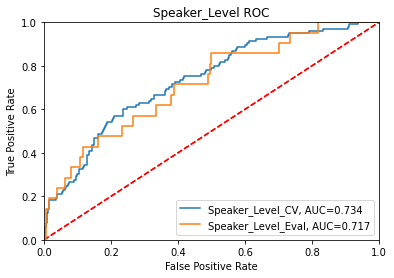

In [62]:
x7 = maxvote6(vowel_form_soft,vowel_fbank_soft,breath_form_soft,breath_fbank_soft,count_form_soft,count_fstats_soft)
conf7 = avg_CV(vowel_form,x7,feat="Speaker_Level_CV",data_type="Speaker_Level")
x8 = maxvote_eval6(vowel_form_eval_soft,vowel_fbank_eval_soft,breath_form_eval_soft,breath_fbank_eval_soft,count_form_eval_soft,count_fstats_eval_soft)
conf8 = avg_CV_eval(breath_form,x8,feat="Speaker_Level_Eval",data_type="Speaker_Level")

### Feature Combination Across All Tasks

In [ ]:
x9 = maxvote3(vowel_fbank_soft,count_fstats_soft,breath_fbank_soft)
conf9 = avg_CV(vowel_fbank,x9,feat="Combined_Fstats_CV",data_type = "Fstats")
x10 = maxvote_eval3(vowel_fbank_eval_soft,count_fstats_eval_soft,breath_fbank_eval_soft)
conf10 = avg_CV_eval(breath_fbank,x10,feat="Combined_Fstats_Eval",data_type="Fstats")

In [ ]:
x11 = maxvote3(vowel_form_soft,count_form_soft,breath_form_soft)
conf11 = avg_CV(vowel_form,x11,feat="Combined_Breath_CV",data_type = "Formants")
x12 = maxvote_eval3(vowel_form_eval_soft,count_form_eval_soft,breath_form_eval_soft)
conf12 = avg_CV_eval(vowel_form,x12,feat="Combined_Breath_Eval",data_type="Formants")